In [639]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ortools.linear_solver import pywraplp
import random
pd.options.display.max_rows = 5000
pd.options.display.max_columns = 500

In [640]:
DIVERSITY_UTILITY = 0.25
FRAC_ADMIT = 0.5


###
## Load dataframe where each row is a single applicant
###

df = pd.read_csv('./df_test.csv')
df['key'] = df['R'].astype(str) + "_"  + df['T'].astype(str)

df_stratum_utility = df[['R','T','B_p']].groupby(['R','T']).mean().reset_index()
df_stratum_utility['stratum_utility'] = (df_stratum_utility['B_p'] + DIVERSITY_UTILITY * df_stratum_utility['R']).round(2)
df_stratum_utility['key'] = df_stratum_utility['R'].astype(str) + "_" + df_stratum_utility['T'].astype(str)

df = df.merge(df_stratum_utility[['stratum_utility','key']], on='key')
df['ml_outcomes'] = df['stratum_utility']

In [641]:
df

,Unnamed: 0,R,I_noise,E_noise,E_black,E_white,M_noise,M_black,M_white,T_noise,T_black,T_white,T_white_star,T_black_star,E,M,T,A_raw,A_raw_black,A_raw_white,A_prob,A,B_p_unif,B_p_reject_noise,B_p,B_p_raw,B_p_reject,B_p_reject_raw,D_p,key,stratum_utility,ml_outcomes
0,1,1,0,-0.845397,-0.845397,0.154603,-1.018190,-2.863587,-1.863587,-3.259841,34,40,35,37,-0.845397,-2.863587,34,-0.65,-0.65,-0.20,0.342990,1,0.429338,-0.377378,0,0.053983,0,0.033453,1,1_34,0.39,0.39
1,75,1,0,0.131618,0.131618,1.131618,-0.690123,-1.558505,-0.558505,-10.101561,34,42,36,38,0.131618,-1.558505,34,-0.65,-0.65,-0.16,0.342990,0,0.595513,-0.854365,0,0.173861,0,0.113196,1,1_34,0.39,0.39
2,269,1,0,-0.899349,-0.899349,0.100651,-0.792874,-2.692223,-1.692223,-4.545429,34,39,35,37,-0.899349,-2.692223,34,-0.65,-0.65,-0.22,0.342990,0,0.292766,-0.801710,0,0.063434,0,0.039459,1,1_34,0.39,0.39
3,482,1,0,-0.782717,-0.782717,0.217283,-0.804420,-2.587137,-1.587137,-4.369570,34,40,36,37,-0.782717,-2.587137,34,-0.65,-0.65,-0.20,0.342990,0,0.215400,-0.337719,0,0.069971,0,0.043641,1,1_34,0.39,0.39
4,737,1,0,-2.371546,-2.371546,-1.371546,-0.227721,-3.599267,-2.599267,-0.544649,34,37,35,36,-2.371546,-3.599267,34,-0.65,-0.65,-0.26,0.342990,0,0.001062,-0.532644,1,0.026616,1,0.016314,1,1_34,0.39,0.39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,81251,1,0,2.892292,2.892292,3.892292,1.357483,3.249775,4.249775,4.421228,88,104,96,95,2.892292,3.249775,88,0.43,0.43,1.08,0.605874,1,0.058329,-0.272167,1,0.962665,1,0.939901,1,1_88,1.25,1.25
99996,81371,1,0,3.245286,3.245286,4.245286,1.472530,3.717816,4.717816,13.122042,103,119,111,110,3.245286,3.717816,103,0.73,0.73,1.38,0.674805,1,0.166037,-0.979975,1,0.976289,1,0.961499,1,1_103,1.25,1.25
99997,81953,0,0,2.155218,2.155218,3.155218,3.455682,4.610900,5.610900,9.459825,96,112,105,103,3.155218,5.610900,112,1.24,0.59,1.24,0.775564,1,0.847258,-0.235855,1,0.996356,1,0.994005,0,0_112,1.00,1.00
99998,86263,0,0,-2.989008,-2.989008,-1.989008,-1.785444,-5.774451,-4.774451,-18.698091,14,14,12,15,-1.989008,-4.774451,14,-0.72,-1.05,-0.72,0.327393,1,0.396592,-0.713042,0,0.008372,0,0.005095,0,0_14,0.00,0.00


In [642]:
FRAC_ADMIT = 0.5#df[['A']].sum()/len(df)


In [643]:
FRAC_ADMIT

0.5

In [644]:
len(df)

100000

<AxesSubplot:>

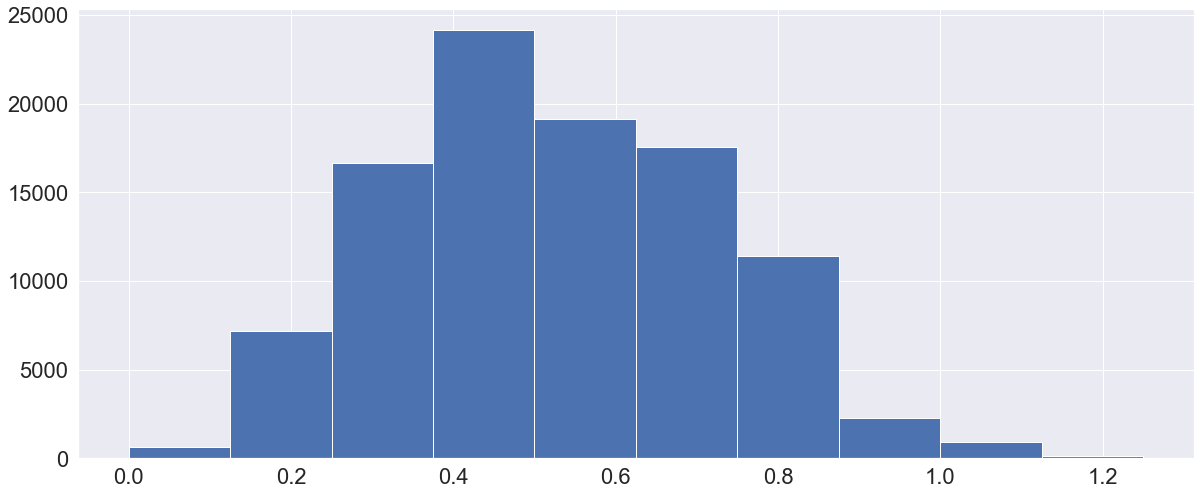

In [645]:
df['ml_outcomes'].hist()

In [646]:
##
# R = race, T = test score, ml_outcomes = expected utility from admitting, 
# ml_outcomes_{} counterfactual utility given race 
##

df[['R','T','ml_outcomes','T_black','T_white','B_p']].sort_values(by='ml_outcomes')



,R,T,ml_outcomes,T_black,T_white,B_p
98627,0,20,0.00,15,20,0
99515,0,19,0.00,17,19,0
99514,0,19,0.00,18,19,0
99920,0,15,0.00,13,15,0
99513,0,19,0.00,18,19,0
...,...,...,...,...,...,...
99369,1,92,1.25,92,105,1
99370,1,92,1.25,92,105,1
99371,1,92,1.25,92,108,1
99943,1,85,1.25,85,98,1


In [647]:
###
## Get total utility from admitting people in a stratum 
###

df_ = df[['R','T','ml_outcomes']].groupby(['R','T']).sum().reset_index()

In [648]:
###
## Get number of people in each stratum
###

df_count = df[['R','T','ml_outcomes']].groupby(['R','T']).count().reset_index()
df_count.columns = ['R','T','Count']
df_count['N'] = df_count['Count']

In [649]:
###
## Get boards passage probability in each stratum
###

df_prob = df[['R','T','B_p']].groupby(['R','T']).mean().reset_index()
df_prob.columns = ['R','T','ml_outcomes_prob']

#df_prob = df[['R','T','ml_outcomes_prob']]

In [650]:
###
## Merge summary tables to get one table with Race, Test Score, SUM(Utility), COUNT(applicants), E(Y(1)|X )
###

dff = df_.merge(df_count[['N']],left_index=True,right_index=True)
dff = dff.merge(df_prob[['ml_outcomes_prob']],left_index=True,right_index=True).sort_values(by='ml_outcomes',ascending=False).reset_index().sort_values(by='index').reset_index()



In [651]:
# final info table
dff.sort_values(by='ml_outcomes_prob')

,level_0,index,R,T,ml_outcomes,N,ml_outcomes_prob
0,191,0,0,14,0.00,1,0.000000
110,171,110,1,17,1.50,6,0.000000
109,170,109,1,16,1.75,7,0.000000
108,178,108,1,15,1.00,4,0.000000
107,184,107,1,14,0.25,1,0.000000
111,156,111,1,18,3.25,13,0.000000
106,183,106,1,12,0.50,2,0.000000
112,150,112,1,19,5.75,23,0.000000
5,188,5,0,19,0.00,10,0.000000
4,189,4,0,18,0.00,6,0.000000


In [652]:
dff['Pr(X=X_j)'] = dff['N']/(dff['N']).sum()

In [653]:
dff[dff['R']==1].sort_values(by='T')

,level_0,index,R,T,ml_outcomes,N,ml_outcomes_prob,Pr(X=X_j)
105,185,105,1,11,0.25,1,0.000000,0.00001
106,183,106,1,12,0.50,2,0.000000,0.00002
107,184,107,1,14,0.25,1,0.000000,0.00001
108,178,108,1,15,1.00,4,0.000000,0.00004
109,170,109,1,16,1.75,7,0.000000,0.00007
110,171,110,1,17,1.50,6,0.000000,0.00006
111,156,111,1,18,3.25,13,0.000000,0.00013
112,150,112,1,19,5.75,23,0.000000,0.00023
113,142,113,1,20,9.62,26,0.115385,0.00026
114,140,114,1,21,11.40,38,0.052632,0.00038


In [ ]:
df_decisions = None
max_utility = -1.0

for C_y in np.linspace(0.0,1.0,10001):
    dff['alpha_j'] = dff['Pr(X=X_j)']* (dff['ml_outcomes_prob'] - C_y)
    solver = pywraplp.Solver.CreateSolver('GLOP')

    
    applicant_stratum = []
    vars_cache = {}
    alpha_j = {}
    
    # Objective: Maximize the expected utility of the admitted students
    objective = solver.Objective()
    
    # For each stratum
    for ix, row in dff.iterrows():
        # probability of admission
        numvar = solver.NumVar(0.0, 1.0, str(ix))
        
        # store variable by index, and also by stratum R, T
        applicant_stratum.append(numvar)
        vars_cache[(row['R'],row['T'])] = numvar
        
        alpha_j[(row['R'],row['T'])] = row['alpha_j']
        
        # Benefit of admitting people is total utility in that stratum
        objective.SetCoefficient(applicant_stratum[ix], float(row['ml_outcomes']))
        
    objective.SetMaximization()

    # Constraint: At most K applicants
    K = int(len(df)*FRAC_ADMIT)
    admit_quota = solver.Constraint(0, K)
    
    # Total admits cannot exceed K 
    for ix, row in dff.iterrows():
        admit_quota.SetCoefficient(applicant_stratum[ix], float(row['N']))
    
    
    sum_alpha = 0
    R = 1 
    
    for T in list(dff[dff['R']==R]['T']):
        sum_alpha+= alpha_j[(R,T)] 
        
    cf_black = solver.Constraint(sum_alpha, sum_alpha)
    
    for T in list(dff[dff['R']==R]['T']):    
        cf_black.SetCoefficient(vars_cache[(R,T)], alpha_j[(R,T)] )    
    
    sum_alpha = 0
    R = 0
    
    for T in list(dff[dff['R']==R]['T']):
        sum_alpha+= alpha_j[(R,T)] 
        
    cf_white = solver.Constraint(sum_alpha, sum_alpha)
    
    for T in list(dff[dff['R']==R]['T']):    
        cf_white.SetCoefficient(vars_cache[(R,T)], alpha_j[(R,T)] )
        
    status = solver.Solve()

    if status != 2:
        TOTAL_UTILITY = 0
        for ix, row in dff.iterrows():
            TOTAL_UTILITY += float(row['ml_outcomes'])* vars_cache[(row['R'],row['T'])].solution_value()
        print(C_y,TOTAL_UTILITY)
        
        if TOTAL_UTILITY > max_utility:
            row = []
            admit = []
        
            for i in applicant_stratum:
                row.append(int(str(i)))
                admit.append(i.solution_value())
            
            df_decisions = pd.DataFrame({'row_id':row,'decision':admit})
            
            max_utility = TOTAL_UTILITY


0.2716 31612.49926201307
0.2717 31612.403356988074
0.2718 31612.31563403417
0.27190000000000003 31612.177984446957
0.272 31612.045902631224
0.2721 31611.922037358763
0.2722 31611.800579776176
0.2723 31611.664147724896
0.27240000000000003 31611.535972798618
0.2725 31611.416076627927
0.2726 31611.304480918956
0.2727 31611.201207453807
0.2728 31611.106278090872
0.27290000000000003 31611.01971476517
0.273 31610.94153948865
0.2731 31610.871774350515
0.2732 31610.805992706977
0.2733 31610.74780405601
0.27340000000000003 31610.698093991767
0.2735 31610.656884920525
0.2736 31610.62419932771
0.2737 31610.600059778044
0.2738 31610.584488915956
0.27390000000000003 31610.577509465937
0.274 31610.579144232994
0.2741 31610.58941610284
0.2742 31610.608348042337
0.2743 31610.63596309986
0.27440000000000003 31610.67228440565
0.2745 31610.717335172183
0.2746 31610.771138694432
0.2747 31610.833718350463
0.2748 31610.905097601604
0.27490000000000003 31610.985299992954
0.275 31611.074349153565
0.2751 31611

0.3018 31741.393544408525
0.3019 31741.453323898568
0.302 31741.520216272907
0.30210000000000004 31741.59423665433
0.3022 31741.675400208667
0.3023 31741.763722144624
0.3024 31741.859217714235
0.3025 31741.961902212865
0.30260000000000004 31742.071790979393
0.3027 31742.188899396388
0.3028 31742.31324289014
0.3029 31742.44483693107
0.303 31742.58369703362
0.30310000000000004 31742.729838756582
0.3032 31742.883277703204
0.3033 31743.044029521316
0.3034 31743.21165626211
0.3035 31743.386311194314
0.30360000000000004 31743.568331600305
0.3037 31743.757733319537
0.3038 31743.95453223694
0.3039 31744.158744283133
0.304 31744.37038543435
0.30410000000000004 31744.58947171291
0.3042 31744.816019187183
0.3043 31745.050043971798
0.3044 31745.29156222781
0.3045 31745.54059016297
0.30460000000000004 31745.797144031683
0.3047 31746.06124013544
0.3048 31746.332894822684
0.3049 31746.612124489242
0.305 31746.89894557838
0.30510000000000004 31747.19337458099
0.3052 31747.495428035756
0.3053 31747.805

0.33140000000000003 31898.623796302596
0.3315 31898.769926543435
0.3316 31898.922246568192
0.3317 31899.080767571228
0.33180000000000004 31899.24550077381
0.33190000000000003 31899.416457424355
0.332 31899.59364879843
0.3321 31899.777086198883
0.3322 31899.96678095585
0.33230000000000004 31900.16274442694
0.33240000000000003 31900.36498799723
0.3325 31900.573295301907
0.3326 31900.787901762684
0.3327 31901.008822591055
0.33280000000000004 31901.23606928285
0.33290000000000003 31901.46965336187
0.333 31901.709586379817
0.3331 31901.95587991663
0.3332 31902.207991265168
0.33330000000000004 31902.466270195546
0.33340000000000003 31902.73094466922
0.3335 31903.00202637951
0.3336 31903.27952704824
0.3337 31903.56345842586
0.33380000000000004 31903.853832291432
0.33390000000000003 31904.150660452953
0.334 31904.45395474717
0.3341 31904.76372703991
0.3342 31905.079989225887
0.33430000000000004 31905.402753229086
0.33440000000000003 31905.732031002703
0.3345 31906.06783452918
0.3346 31906.4101

0.3593 31984.669417976325
0.3594 31984.46470329625
0.35950000000000004 31984.26460163209
0.35960000000000003 31984.064707699654
0.3597 31983.86746444043
0.3598 31983.674855170964
0.3599 31983.486886573297
0.36000000000000004 31983.302655641433
0.36010000000000003 31983.122092331316
0.3602 31982.946184431505
0.3603 31982.774938667808
0.3604 31982.60836177896
0.36050000000000004 31982.446460516803
0.36060000000000003 31982.28924164603
0.3607 31982.136711944568
0.3608 31981.988878203298
0.3609 31981.845747226285
0.36100000000000004 31981.707325830743
0.36110000000000003 31981.57362084706
0.3612 31981.444639118832
0.3613 31981.320387502896
0.3614 31981.200872869398
0.36150000000000004 31981.086102101774
0.36160000000000003 31980.976082096764
0.3617 31980.870819764594
0.3618 31980.77032202877
0.3619 31980.674595826305
0.36200000000000004 31980.58364810772
0.36210000000000003 31980.49748583695
0.3622 31980.41611599153
0.3623 31980.339545562558
0.3624 31980.267781554747
0.36250000000000004 31

0.3885 32044.758298450455
0.3886 32044.534658689314
0.38870000000000005 32044.31494226231
0.38880000000000003 32044.099154006497
0.3889 32043.88729876676
0.389 32043.679381395978
0.3891 32043.475406755104
0.38920000000000005 32043.275379712966
0.38930000000000003 32043.07930514649
0.3894 32042.887187940636
0.3895 32042.69903298841
0.3896 32042.51484519087
0.38970000000000005 32042.334629457153
0.38980000000000004 32042.158390704546
0.3899 32041.986133858412
0.39 32041.81786385231
0.3901 32041.653585627828
0.3902 32041.493304134896
0.39030000000000004 32041.337024331486
0.3904 32041.18475118383
0.3905 32041.036489666396
0.3906 32040.89224476185
0.3907 32040.75202146116
0.39080000000000004 32040.61582476358
0.3909 32040.483659676524
0.391 32040.355531215882
0.3911 32040.231444405763
0.3912 32040.11140427869
0.39130000000000004 32039.995415875408
0.3914 32039.88278726651
0.3915 32039.774143067283
0.3916 32039.66956454739
0.3917 32039.569056779652
0.39180000000000004 32039.47262484554
0.39

0.4169 31415.684558082095
0.41700000000000004 31410.79640086426
0.4171 31405.908243646438
0.4172 31401.020086428616
0.4173 31396.131929210802
0.4174 31391.24377199298
0.41750000000000004 31386.35561477516
0.4176 31381.467457557334
0.4177 31376.57930033951
0.4178 31371.69114312169
0.4179 31366.80298590388
0.41800000000000004 31361.914828686058
0.4181 31357.026671468233
0.4182 31352.13851425042
0.4183 31347.250357032593
0.4184 31342.362199814776
0.41850000000000004 31337.474042596947
0.4186 31332.585885379136
0.4187 31327.697728161314
0.4188 31322.8087455473
0.4189 31317.91560989697
0.41900000000000004 31313.022474246634
0.41910000000000003 31308.1293385963
0.4192 31303.23620294597
0.4193 31298.343067295613
0.4194 31293.449931645297
0.41950000000000004 31288.55679599497
0.41960000000000003 31283.66366034464
0.4197 31278.770524694315
0.4198 31273.877389043973
0.4199 31268.984253393643
0.42000000000000004 31264.091117743308
0.42010000000000003 31259.197982092977
0.4202 31254.30484644264
0.

0.4456 30006.44538427134
0.44570000000000004 30001.50663188278
0.44580000000000003 29996.567879494207
0.4459 29991.629127105658
0.446 29986.69037471706
0.4461 29981.751622328527
0.44620000000000004 29976.812869939942
0.44630000000000003 29971.874117551357
0.4464 29966.93536516281
0.4465 29961.996612774237
0.4466 29957.05786038567
0.44670000000000004 29952.119107997103
0.44680000000000003 29947.180355608543
0.4469 29942.241603219976
0.447 29937.302850831406
0.4471 29932.364098442842
0.44720000000000004 29927.423468683428
0.44730000000000003 29922.48169739731
0.4474 29917.538876389524
0.4475 29912.59605538173
0.4476 29907.653234373938
0.44770000000000004 29902.710413366138
0.44780000000000003 29897.767592358367
0.4479 29892.824771350577
0.448 29887.88195034278
0.4481 29882.939129334995
0.44820000000000004 29877.996308327198
0.44830000000000003 29873.05348731941
0.4484 29868.11066631163
0.4485 29863.167845303837
0.4486 29858.225024296058
0.44870000000000004 29853.282203288258
0.4488000000

0.4736 28616.994107456732
0.4737 28612.019834093626
0.4738 28607.04556073052
0.47390000000000004 28602.071287367406
0.47400000000000003 28597.097014004306
0.4741 28592.122740641207
0.4742 28587.148467278093
0.4743 28582.174193914987
0.47440000000000004 28577.19992055186
0.47450000000000003 28572.225647188752
0.4746 28567.25137382566
0.4747 28562.277100462547
0.4748 28557.30282709944
0.47490000000000004 28552.32855373631
0.47500000000000003 28547.354280373205
0.4751 28542.380007010113
0.4752 28537.40573364701
0.4753 28532.431460283908
0.47540000000000004 28527.45718692078
0.47550000000000003 28522.482913557673
0.4756 28517.508640194555
0.4757 28512.53436683146
0.4758 28507.560093468353
0.47590000000000005 28502.585820105247
0.47600000000000003 28497.611546742126
0.4761 28492.63727337902
0.4762 28487.663000015906
0.4763 28482.688726652814
0.47640000000000005 28477.714453289693
0.47650000000000003 28472.7401799266
0.4766 28467.765906563483
0.4767 28462.79163320036
0.4768 28457.81713945339

0.5007 27264.694503765037
0.5008 27259.67998880062
0.5009 27254.665473836216
0.501 27249.650958871796
0.5011 27244.636443907388
0.5012 27239.62192894298
0.5013000000000001 27234.607413978556
0.5014000000000001 27229.59289901415
0.5015000000000001 27224.578384049724
0.5016 27219.563869085323
0.5017 27214.5493541209
0.5018 27209.534839156495
0.5019 27204.520324192083
0.502 27199.50580922768
0.5021 27194.491294263247
0.5022 27189.47677929885
0.5023 27184.462264334452
0.5024000000000001 27179.44659768465
0.5025000000000001 27174.430718164105
0.5026 27169.41483864357
0.5027 27164.398959123024
0.5028 27159.38307960249
0.5029 27154.367200081942
0.503 27149.3513205614
0.5031 27144.33544104087
0.5032 27139.31956152033
0.5033 27134.303681999787
0.5034000000000001 27129.28780247924
0.5035000000000001 27124.271922958706
0.5036 27119.25604343816
0.5037 27114.240163917628
0.5038 27109.224284397067
0.5039 27104.208404876543
0.504 27099.192525355997
0.5041 27094.176645835472
0.5042 27089.1603804514
0.

0.53 25791.788954421958
0.5301 25786.739816249876
0.5302 25781.690678077783
0.5303 25776.64153990572
0.5304 25771.59240173363
0.5305 25766.54105803449
0.5306000000000001 25761.489533610053
0.5307000000000001 25756.438009185596
0.5308 25751.386484761155
0.5309 25746.334960336706
0.531 25741.283435912243
0.5311 25736.231911487805
0.5312 25731.180387063356
0.5313 25726.128862638925
0.5314 25721.077338214473
0.5315 25716.02581379002
0.5316000000000001 25710.974289365582
0.5317000000000001 25705.922764941137
0.5318 25700.871240516684
0.5319 25695.819716092235
0.532 25690.76819166778
0.5321 25685.71666724336
0.5322 25680.66514281889
0.5323 25675.613618394444
0.5324 25670.56209397001
0.5325 25665.510569545553
0.5326000000000001 25660.45904512111
0.5327000000000001 25655.407520696663
0.5328 25650.355996272217
0.5329 25645.304471847765
0.533 25640.252947423312
0.5331 25635.201422998878
0.5332 25630.14989857444
0.5333 25625.098374149984
0.5334 25620.046849725557
0.5335 25614.995325301097
0.53360

0.5591 24315.37804803554
0.5592 24310.27673429663
0.5593 24305.17542055774
0.5594 24300.074106818833
0.5595 24294.97279307993
0.5596 24289.871479341033
0.5597 24284.770165602153
0.5598000000000001 24279.66885186323
0.5599000000000001 24274.567538124335
0.56 24269.46622438544
0.5601 24264.36491064655
0.5602 24259.263596907644
0.5603 24254.16228316874
0.5604 24249.06096942985
0.5605 24243.959655690942
0.5606 24238.85834195206
0.5607 24233.757028213135
0.5608000000000001 24228.655714474244
0.5609000000000001 24223.55440073534
0.561 24218.45308699644
0.5611 24213.35108821716
0.5612 24208.248657357897
0.5613 24203.146226498615
0.5614 24198.043795639333
0.5615 24192.941364780076
0.5616 24187.838933920793
0.5617 24182.73650306149
0.5618000000000001 24177.634072202225
0.5619000000000001 24172.531641342935
0.562 24167.42722821521
0.5621 24162.31895355595
0.5622 24157.21067889669
0.5623 24152.10240423743
0.5624 24146.99412957819
0.5625 24141.88585491891
0.5626 24136.77758025966
0.5627 24131.6693

0.5893 22438.528932147197
0.5894 22428.703009439003
0.5895 22418.880925197824
0.5896 22409.062674808272
0.5897 22399.248253662205
0.5898 22389.437657158942
0.5899 22379.63088070517
0.5900000000000001 22369.82791971488
0.5901000000000001 22360.02876960951
0.5902000000000001 22350.233425817692
0.5903 22340.441883775475
0.5904 22330.649981400806
0.5905 22320.85746317502
0.5906 22311.065518548694
0.5907 22301.2773555186
0.5908 22291.49296955944
0.5909 22281.71235615305
0.5910000000000001 22271.9355107886
0.5911000000000001 22262.16242896231
0.5912000000000001 22252.393106177624
0.5913 22242.627537945293
0.5914 22232.865719782974
0.5915 22223.107647215613
0.5916 22213.3533157752
0.5917 22203.602721000894
0.5918 22193.85585843886
0.5919 22184.112723642473
0.5920000000000001 22174.373312171963
0.5921000000000001 22164.636945857736
0.5922000000000001 22154.90350496783
0.5923 22145.173773887804
0.5924 22135.44774820631
0.5925 22125.725423519103
0.5926 22116.006795428977
0.5927 22106.29185954549

## Add CF Predictive Parity Constraints

In [ ]:
max_utility

In [ ]:
dff.merge(df_decisions,left_index=True,right_index=True).sort_values(by='ml_outcomes',ascending=False)

In [ ]:
xxx_ = dff.merge(df_decisions,left_index=True,right_index=True).sort_values(by='ml_outcomes',ascending=False)
xxx_.sort_values(by='T')

In [ ]:
xxx = dff.merge(df_decisions,left_index=True,right_index=True).sort_values(by='ml_outcomes',ascending=False)
xxx

In [ ]:
len(xxx_)

In [ ]:
xxx.to_csv('./decision.csv')

In [ ]:
solution = pd.read_csv('./decision.csv')

In [ ]:
xxx

In [ ]:
(xxx['ml_outcomes']*xxx['decision']).sum()

In [ ]:
def maxMLOutcomes(frac_black=0.01):
    black_admits = int(K*frac_black)
    white_admits = int(K*(1-frac_black))
    
    b = df[df['R']==1].sort_values(by='ml_outcomes',ascending=False).head(n=black_admits)
    w = df[df['R']==0].sort_values(by='ml_outcomes',ascending=False).head(n=white_admits)
    
    return b['B_p'].sum() + w['B_p'].sum()    

In [ ]:
def maxMLOutcomesBlack(frac_black=0.01):
    black_admits = int(K*frac_black)
    white_admits = int(K*(1-frac_black))
    
    b = df[df['R']==1].sort_values(by='ml_outcomes',ascending=False).head(n=black_admits)
    w = df[df['R']==0].sort_values(by='ml_outcomes',ascending=False).head(n=white_admits)
    
    return b['B_p'].sum()   

In [ ]:
df['key'] = df['R'].astype(str)+'_'+df['T'].astype(str)
xxx['key'] = xxx['R'].astype(str)+'_'+xxx['T'].astype(str)

In [ ]:
len(xxx)

In [ ]:
admit_decisions = df.merge(xxx,how='left',on='key')
admit_decisions['decision_random'] = pd.Series([random.random() for x in range(0,len(admit_decisions))]) < FRAC_ADMIT


FRAC_BLACK_POLICY = (admit_decisions['R_y'] * admit_decisions['decision']).sum()/admit_decisions['decision'].sum()
SUM_BP_POLICY = ( admit_decisions['B_p'] * admit_decisions['decision']).sum()

FRAC_RANDOM_POLICY = (admit_decisions['R_y'] * admit_decisions['decision_random']).sum()/admit_decisions['decision_random'].sum()
SUM_BP_RAND_POLICY = ( admit_decisions['B_p'] * admit_decisions['decision_random']).sum()


In [ ]:
str(FRAC_BLACK_POLICY),str(SUM_BP_POLICY)

In [ ]:
file = open('./lp_results.csv','a')
file.write('{}\t{}\t{}\n'.format('Counterfactual Pred. Parity',str(FRAC_BLACK_POLICY),str(SUM_BP_POLICY)))
file.close()


In [ ]:
(xxx['N']*xxx['decision']).sum()/len(df)

In [ ]:
sns.set(rc={'figure.figsize':(20,8.27)})
sns.set(font_scale=2)  # crazy big
g = sns.scatterplot(x='T',y='decision',hue='R',data=xxx[xxx['R']==1])
g.set(xlim=(0, 150))
plt.axvline(70.5, 0,1,color='red')


In [ ]:
sns.set(rc={'figure.figsize':(20,8.27)})
sns.set(font_scale=2)  # crazy big
g = sns.scatterplot(x='T',y='decision',hue='R',data=xxx[xxx['R']==0])
g.set(xlim=(0, 150))
plt.axvline(52.5, 0,1,color='red')



In [ ]:
admit_decisions[admit_decisions['decision']==0][['R_x','B_p']].groupby(['R_x']).mean()

In [ ]:
str(FRAC_BLACK_POLICY),str(SUM_BP_POLICY)

In [ ]:
SUM_BP_POLICY/(FRAC_ADMIT*len(df))

In [ ]:
str(FRAC_BLACK_POLICY),str(SUM_BP_POLICY)

In [ ]:
admit_decisions[admit_decisions['decision']==1]['B_p'].mean()

In [ ]:
(admit_decisions['decision'] * admit_decisions['ml_outcomes_x']).sum()

In [ ]:
(admit_decisions['decision'] * admit_decisions['B_p']).sum()

In [ ]:
admit_decisions[admit_decisions['decision']==1]['B_p'].sum()

In [ ]:
(admit_decisions['decision'] * admit_decisions['B_p']).sum()/(len(admit_decisions)*FRAC_ADMIT)

In [ ]:
(admit_decisions['decision'].sum())

In [ ]:
admit_decisions['rand'] = pd.Series([random.random() for x in range(0,len(admit_decisions))])
admit_decisions['dec_binary'] = admit_decisions['rand'] < admit_decisions['decision']


In [ ]:
admit_decisions[admit_decisions['dec_binary']==0][['R_x','B_p']].groupby(['R_x']).mean()

In [ ]:
admit_decisions['R_x'].value_counts()